# Introduction
I chose the "Rain in Australia" dataset from Kaggle: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
> This dataset contains about 10 years of daily weather observations from numerous Australian weather stations.

It has categorical and numerical features, some missing values. The original task was to predict it rain will fall the day after, but I will use it to make broader forecasting on all the dataset.

### Plan

**1.Quick EDA & Engineering of the dataset**

**2.Stationarity checks**


**3.Forecasting**

    **3.1 SARIMAX forecasting**

    **3.2 VAR Forecasting**
    
    **3.3 LSTM Forecasting**

**4.Conclusion**

**1.Quick EDA & Engineering of the dataset**

In [1]:
# First imports for EDA and Management
from IPython.display import display

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno

from math import floor
from scipy.stats import boxcox

%matplotlib inline

In [2]:
# Opening dataset
raw_data = pd.read_csv('C:/Users/Syla/CourseRA/weatherAUS.csv')

In [3]:
def check_for_nans(df):
    ''' This function will count the number of Nans in the dataframe and return a frame showing the percentage 
    per feature if there are any'''
    n_nan = (df.isna().sum())  # counting the number of Nan values
    n_nan = n_nan[n_nan > 0] # Keep only the features if there are Nan inside
    
    
    if n_nan.shape[0] > 0: # If there are Nan values, show the percentage per feature
        print('\033[1m' + 'There are NaN Values in the dataset.' + '\033[0m')
        percent_nan = n_nan / df.shape[0] * 100
        df_nan = pd.DataFrame({'feature': n_nan.index, 
                               'number_nan': n_nan.values, 
                               'percent_nan':percent_nan.values})
        
        return df_nan.sort_values(by='percent_nan', ascending = False)
        
    else: # If there are no Nan values, simply say it.
        print('\033[1m' + 'There are no NaN values in the dataset.' + '\033[0m')
    
        return


def describe_all(df):
    ''' This function simply concatenates many standard tools for the description of the dataframe. 
    '''
    
    print('\033[1m' + 'Data dimensions (row, col) : ' + '\033[0m' + str(df.shape))
    print("\n")
    
    print('\033[1m' + 'Header:' + '\033[0m')
    display(df.head())   
    print("\n")
    
    print('\033[1m' + 'Data dtypes:' + '\033[0m')
    display(df.dtypes)
    print("\n")
    
    print('\033[1m' + 'Description:' + '\033[0m')
    display(df.describe().T)
    print("\n")
    
    print('\033[1m' + 'Column names: ' + '\033[0m' + str(df.columns.tolist()))
    print("\n")
    
    return

def count_unique_strings(df):
    '''This function will check if there are some objects features, and count their numbers of uniques'''
    mask = df.dtypes == "object"
    str_cols = df.columns[mask]
    
        
    if str_cols.shape[0] > 0: 
        print('\033[1m' + 'There are object features in the dataset.' + '\033[0m')
        
        df_str = pd.DataFrame()
        
        for i, col in enumerate(str_cols):
            df_str2 = pd.DataFrame({'feature': col, 
                                    'n_uniques': df[col].nunique(),
                                    'unique_list':np.array2string(df[col].unique())}, 
                                   index = [i])
            df_str = df_str.append(df_str2)
            
            
        return df_str
        
        
    else: # If there are no object features, simply say it.
        print('\033[1m' + 'There are no object features in the dataset.' + '\033[0m')
    
        return

In [4]:
# Full description
describe_all(raw_data)

Data dimensions (row, col) : (145460, 23)


Header:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No




Data dtypes:


Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object



Description:


,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0




Column names: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']




We can see from this quick look that we have numerical and categorical variables. Column names are pretty indicative as is. What about NaNs?

In [5]:
check_for_nans(raw_data)

There are NaN Values in the dataset.


,feature,number_nan,percent_nan
4,Sunshine,69835,48.009762
3,Evaporation,62790,43.166506
16,Cloud3pm,59358,40.807095
15,Cloud9am,55888,38.421559
13,Pressure9am,15065,10.356799
14,Pressure3pm,15028,10.331363
7,WindDir9am,10566,7.263853
5,WindGustDir,10326,7.098859
6,WindGustSpeed,10263,7.055548
12,Humidity3pm,4507,3.098446


Some columns have many NaNs (>40%). Let us visualize them with missingno:

<AxesSubplot:>

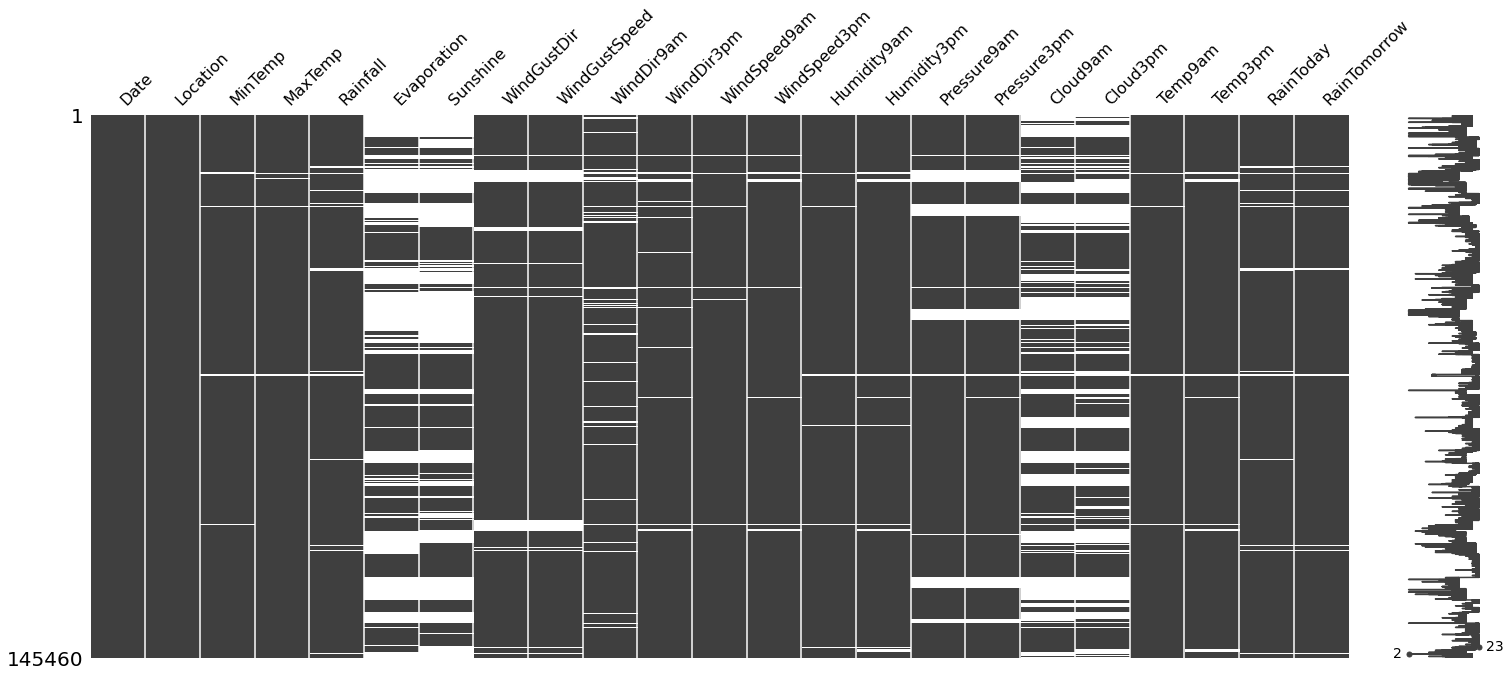

In [6]:
msno.matrix(raw_data)

The columns 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm' have too many NaNs, I will drop them. To simplify things, and as I will try to forecast numerical data, I will drop the categorical values as well.

In [7]:
to_drop = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RainTomorrow', 'WindDir9am', 'WindDir3pm', 'WindGustDir']
data = raw_data.drop(to_drop, axis = 1).copy(deep=True)


To simplify things, I will do forecasting on a single location (there are 49 different towns in this dataset). But I would like to predict the 'rainfall' feature in the end, so let's pick a place where it rains a bit. Australia can be quite a dry country...

In [8]:
# First, replacing the values Yes/No in 'RainToday' by 1/0.
bool_map = {'No':0, 'Yes':1}
data.replace({'RainToday':bool_map}, inplace = True)

In [9]:
# Then, simply group by location, sum the values of 'RainToday' and divide by the total count.
rain_subset = data[['Location', 'RainToday']]

rain_ratio = rain_subset.groupby('Location').sum() / rain_subset.groupby(['Location']).count()

# And show them sorted.
rain_ratio.sort_values('RainToday', ascending=False)[:5]

,RainToday
Location,
Portland,0.365154
Walpole,0.336644
Cairns,0.317938
Dartmoor,0.313052
NorfolkIsland,0.310054


We will pick the town of Portland.


In [10]:
data = data[data['Location'] == 'Portland']

Now, we have to manage the NaNs values in our dataset. I will do something really simple as the exercise is about something else: simply replace them by interpolation. But to do so, we have to sort our data by year and day of the year. So first, I construct multiple time features from the Date feature:

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = pd.to_datetime(data['Date']).dt.year.astype(float) 
data['DayYear'] = pd.to_datetime(data['Date']).dt.dayofyear.astype(float)

data['Month'] = pd.to_datetime(data['Date']).dt.month.astype(float)

Now, let's interpolate our data to fill the NaNs:

In [12]:
data.sort_values(by = ['Year','DayYear'],inplace = True)
data.interpolate(method = 'spline', order=3, inplace = True)

And I will use montly values to decrease the size of our dataset. I could use the full timescale, but the computing time explodes in the forecasting steps.

In [13]:
df = data.groupby(['Year', 'Month']).mean()

What does it look like?

<AxesSubplot:xlabel='Year,Month'>

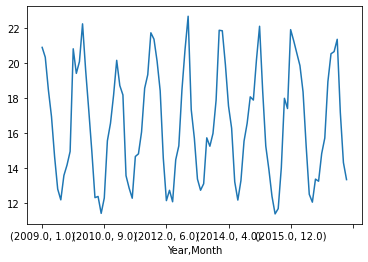

In [14]:
df['Temp3pm'].plot()

It seems fine! And are there any NaNs?

In [15]:
check_for_nans(df)

There are no NaN values in the dataset.


This looks fine at first glance, but actually it is not: values for 3 months are missing in the dataset. This seems nothing, but this will mess up our next steps. Forecasting models don't like missing time steps... So I will reconstruct a time index and substitute it, then interpolate the missing data.

In [16]:
# Let's create a new dataframe
df2 = df.reset_index()

# With a new, clean Date feature
df2['Date'] = pd.to_datetime(df2[['Year', 'Month']].assign(day=1))

# ANd pass it as index.
df2 = df2.set_index('Date')

In [17]:
# This is our new, accurate time index
time_index = pd.date_range(start=df2.index.min(), end=df2.index.max(), freq='MS')

In [18]:
# Reindexing here
df2 = df2.reindex(time_index, method=None)

# Interpolating here.
df2 = df2.interpolate(method='spline', order=3)

In [19]:
# What changed?
print(df.shape)
print(df2.shape)

(99, 14)
(102, 16)


As we can see 3 months were missing in our original dataset. It is corrected and we can drop all our time features as the index is fine now. Dropping the 'RainToday' feature as well, as we used it only to pick the town.

In [20]:
df2 = df2.drop(['Year', 'Month', 'DayYear', 'RainToday'], axis = 1)

In [21]:
# And there are no NaNs
check_for_nans(df2)

There are no NaN values in the dataset.


Do we have any correlated features?

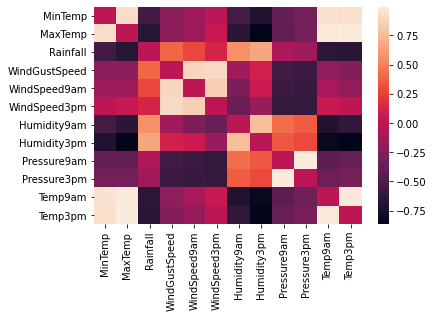

In [22]:
corr_mat = df2.corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0

sns.heatmap(corr_mat, annot=False)
plt.show()


Some strongly correlated features indeed! Let us check them better:

In [23]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df, n=5):
    '''Calculate correlations of pairwise features'''
    au_corr = df.corr().abs().unstack() # I discovered Unstack!
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Obtained Correlations")
print(get_top_correlations(df2, 10))

Obtained Correlations
MaxTemp        Temp3pm         0.996298
Pressure9am    Pressure3pm     0.990695
MaxTemp        Temp9am         0.977571
Temp9am        Temp3pm         0.975697
MinTemp        Temp9am         0.951415
               Temp3pm         0.938906
               MaxTemp         0.929753
WindGustSpeed  WindSpeed3pm    0.902668
               WindSpeed9am    0.892357
MaxTemp        Humidity3pm     0.865697
dtype: float64


Some highly correlated features and this is not suprising: 'MaxTemp' and 'Temp3pm' are expected to be correlated. We could do some nice dimensionaity reduction by PCA here, but it is not the point of the exercise. Anyway, all those features are expected when measuring weather components, so I will keep them like this.

This small EDA / Management is finished, what does it look like?

We can plot a single feature:

<AxesSubplot:>

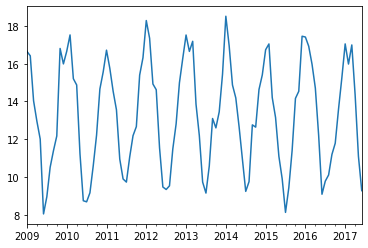

In [24]:
df2['Temp9am'].plot()

Temperature shows strong seasonality, which is expected. We can plot all the features as well:

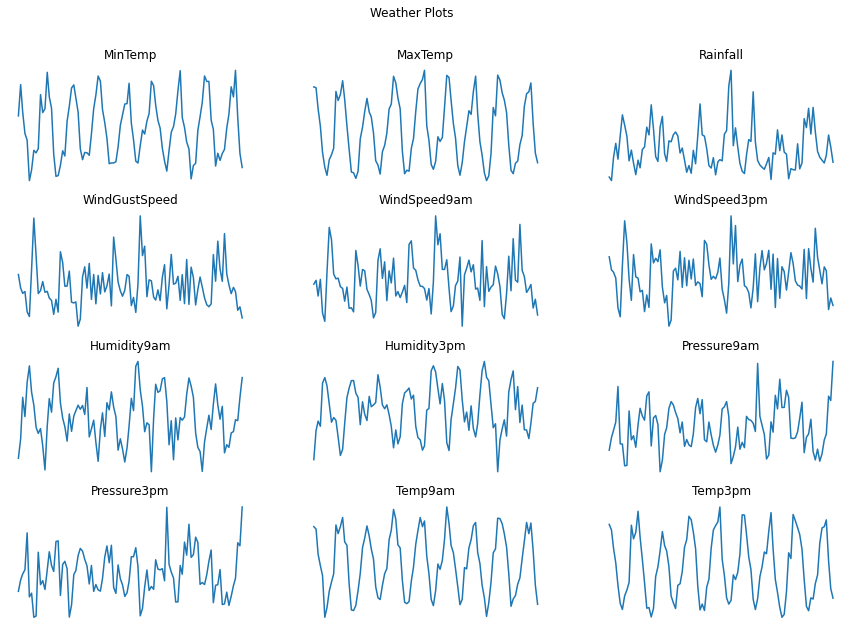

In [25]:
def all_plot(df):
       
    feature_list = [x for x in df.columns]
    plt.figure(figsize=(15, 10))
    plt.suptitle('Weather Plots')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    n_cols = 3
    n_rows = len(feature_list) // n_cols
    
    for i, feature in enumerate(feature_list):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.plot(df[feature])
        plt.title(feature)

        plt.axis("off")
               
        
all_plot(df2)


We can see that every feature shows some seasonality, but beside this they seem stationary. We will check now.

### 2. Stationarity tests

First, let's plot the histograms of the features:

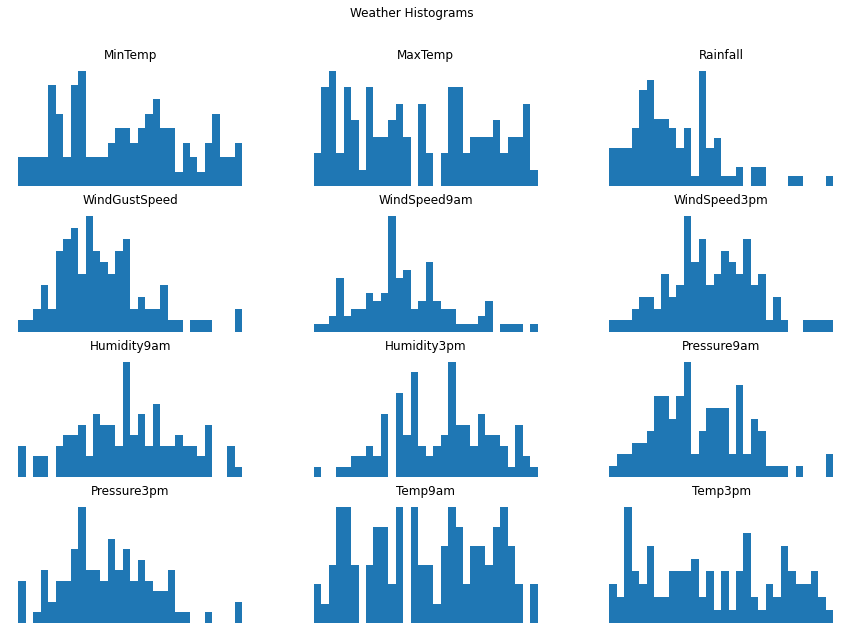

In [26]:
def all_hist(df):
    feature_list = [x for x in df.columns]
    plt.figure(figsize=(15, 10))
    plt.suptitle('Weather Histograms')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    n_cols = 3
    n_rows = len(feature_list) // n_cols
    
    for i, feature in enumerate(feature_list):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.hist(df[feature], bins=30)
        plt.title(feature)

        plt.axis("off")
    
all_hist(df2)

We can see that except 'Rainfall' and 'WindGustSpeed', nothing is really skewed. But let's check the skewness:

In [27]:
def check_skew(df, skew_limit=0.5):
    '''This function will populate a dataframe with the skewness of the distribution'''
    mask = df.dtypes == "float64"
    float_cols = df.columns[mask]
   
    skew_vals = df[float_cols].skew()
    

    skew_cols = (skew_vals
                 .sort_values(ascending=False)
                 .to_frame()
                 .rename(columns={0:'Skew'})
                 .query('abs(Skew) > {0}'.format(skew_limit)))
    
    return skew_cols

check_skew(df2, skew_limit=0.7)

,Skew
Rainfall,1.076461
WindGustSpeed,0.894647


As expected, only 2 columns are skewed. We will correct them by taking their log.

In [28]:
to_deskew = ['Rainfall', 'WindGustSpeed']

for feature in to_deskew:
    df2[feature] = np.log1p(df2[feature])

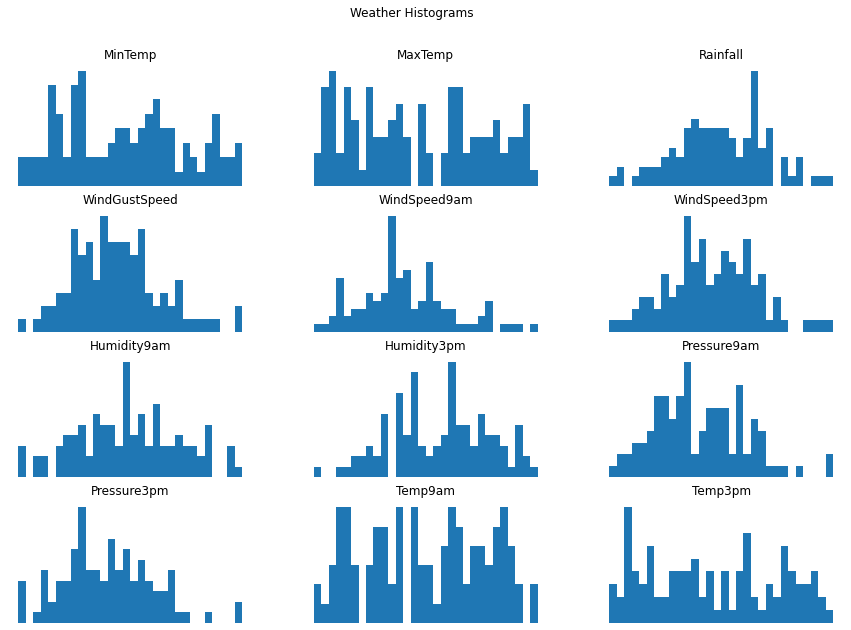

In [29]:
all_hist(df2)

This is already better. Now, let us check the stationarity with the Augmented Dickey–Fuller test:

In [30]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    
    feature_list = [x for x in df.columns]

    df_stats = pd.DataFrame()
    for feature in feature_list:
        
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df[feature])
        stats_dict={'adf': adf, 'pvalue': pvalue, 'usedlag': usedlag, 
                    'nobs': nobs, 'stationary': 'True' if pvalue < 0.05 else 'False'}
        stats = pd.DataFrame.from_dict(stats_dict, orient = "index")
        df_stats = pd.concat([df_stats,stats], axis=1)

    df_stats.columns = feature_list
 
    return df_stats

check_stationarity(df2)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
adf,-2.38296,-2.22457,-6.09331,-5.31758,-5.71214,-5.768,-1.85511,-2.73728,-5.52182,-5.95884,-1.97855,-3.01586
pvalue,0.146604,0.197449,1.02411e-07,5.03471e-06,7.25858e-07,5.47534e-07,0.353463,0.0678056,1.87023e-06,2.06214e-07,0.296056,0.0334397
usedlag,11,10,4,7,7,7,13,13,0,0,11,9
nobs,90,91,97,94,94,94,88,88,101,101,90,92
stationary,False,False,True,True,True,True,False,False,True,True,False,True


Surprisingly, we can see that many features are not stationary according to this test. This was unexpected, as they 'look' stationary (we have to remember that a seasonal variation can be still stationary, as long the seasonal pattern is stable (see https://stats.stackexchange.com/questions/131092/does-a-seasonal-time-series-imply-a-stationary-or-a-non-stationary-time-series).

I do think this is an artifact because of my really few observations (only 102 observations for each feature, as I grouped by month). Actually, if I do the same test to the dataset before the interpolation it gives all stationary features:

In [31]:
check_stationarity(df)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,DayYear
adf,-7.93124,-8.096,-6.22578,-5.49959,-5.83574,-6.07577,-7.76839,-7.01658,-5.56341,-5.97781,-8.85407,-3.32766,-7.58106,-3.23192
pvalue,3.50848e-12,1.33862e-12,5.09297e-08,2.08583e-06,3.88056e-07,1.1226e-07,9.05811e-12,6.70872e-10,1.52371e-06,1.86935e-07,1.54488e-14,0.0136866,2.68114e-11,0.01821
usedlag,6,5,5,7,6,7,5,4,0,0,5,9,6,11
nobs,92,93,93,91,92,91,93,94,98,98,93,89,92,87
stationary,True,True,True,True,True,True,True,True,True,True,True,True,True,True


As a result, I think this an artifact because of my lack of observations, I considered the features stationary and continued the exercise: forecasting.

### 3.1 SARIMAX

Let's check auto-correlation graphs:

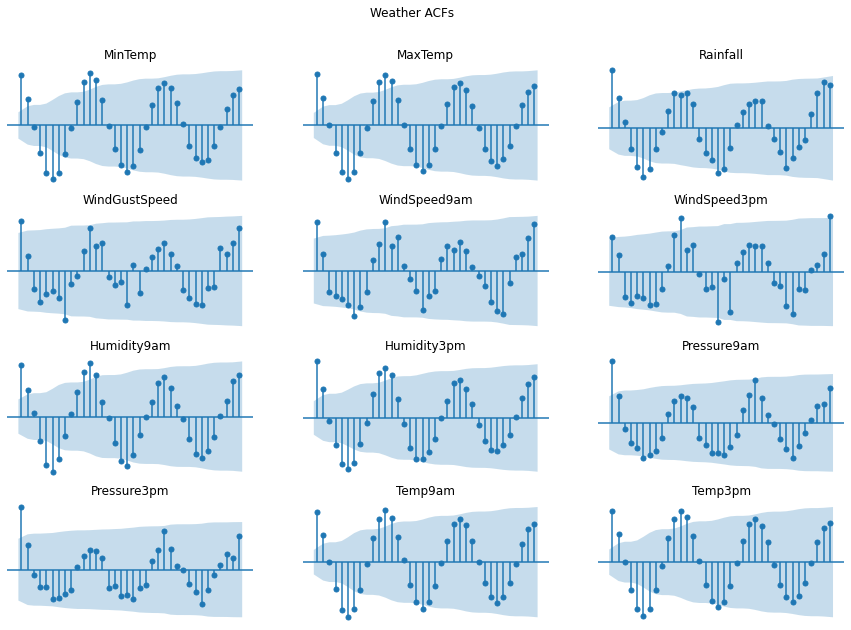

In [32]:
import statsmodels.api as sm
def all_acf(df, lags = 36):
    feature_list = [x for x in df.columns]
    plt.figure(figsize=(15, 10))
    plt.suptitle('Weather ACFs')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    n_cols = 3
    n_rows = len(feature_list) // n_cols
    
    for i, feature in enumerate(feature_list):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        sm.tsa.graphics.plot_acf(df[feature], lags=lags, ax=ax, zero = False)
        plt.title(feature)

        plt.axis("off")
        
all_acf(df2, lags=36)    

And partial autocorrelation graphs:

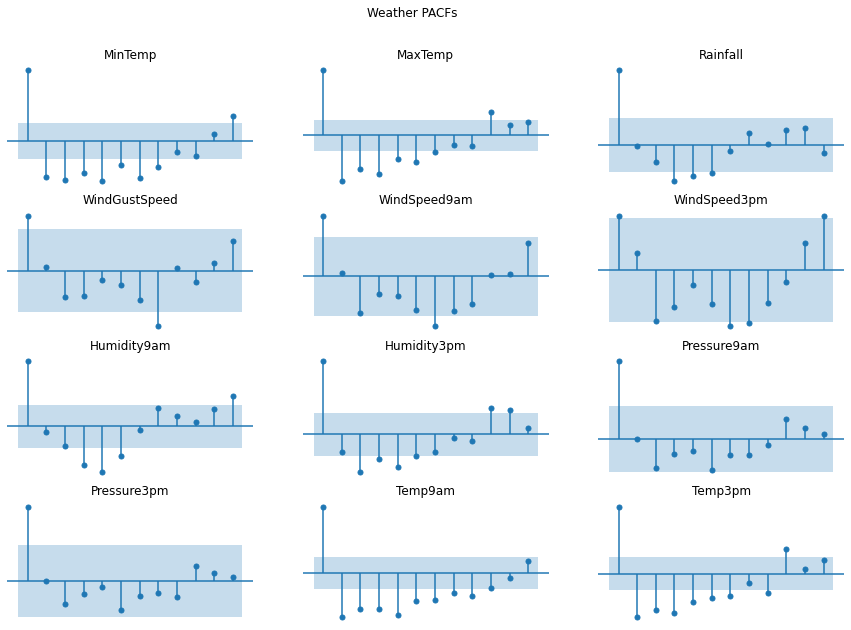

In [33]:
def all_pacf(df, lags = 36):
    feature_list = [x for x in df.columns]
    plt.figure(figsize=(15, 10))
    plt.suptitle('Weather PACFs')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    n_cols = 3
    n_rows = len(feature_list) // n_cols
    
    for i, feature in enumerate(feature_list):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        sm.tsa.graphics.plot_pacf(df[feature], lags=lags, ax=ax, zero = False)
        plt.title(feature)

        plt.axis("off")
        
all_pacf(df2, lags=12)    

We can see we have a clear seasonal effect on 12 months (which is... well... trivial), an auto-regressive component of 1 and a moving average of 1. No visible trend so trend='c' (constant). Let's quickly fit a SARIMAX model on one of the feature with these settings:

In [34]:
sar = sm.tsa.statespace.SARIMAX(df2['Humidity3pm'], missing='drop',
                                order=(1,0,0), 
                                seasonal_order=(1,1,1,12), 
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Humidity3pm   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -250.088
Date:                              Wed, 30 Jun 2021   AIC                            510.176
Time:                                      21:47:38   BIC                            522.675
Sample:                                  01-01-2009   HQIC                           515.216
                                       - 06-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0637      0.146      0.435      0.663      -0.223       0.351
ar.L1          0.3356      0.099      3.374      0.001       0.141       0.531
ar.S.L12      -0.0633      0.198     -0.320      0.749      -0.452       0.325
ma.S.L12      -0.9995    144.225     -0.007      0.994    -283.675     281.676
sigma2        11.2316   1618.901      0.007      0.994   -3161.756    3184.219
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.73   Prob(JB):                         0.26
Heteroskedasticity (H):               1.50   Skew:                            -0.42
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Helper function
def plots(data, lags=None):
    layout = (1, 3)
    plt.figure(figsize=(15, 5))
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

And plot the residual of the fit:

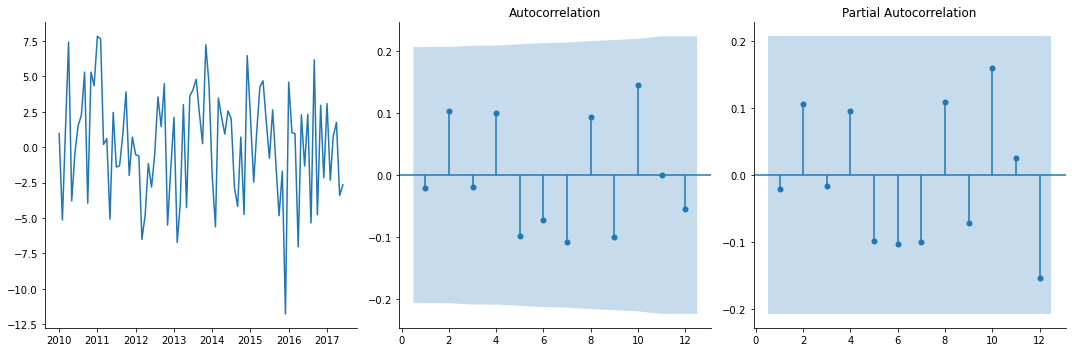

In [36]:
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

We can see that the seasonality disappeared, ACF and PACF are now non-significant. This is a good sign. Let's check the diagnostics:

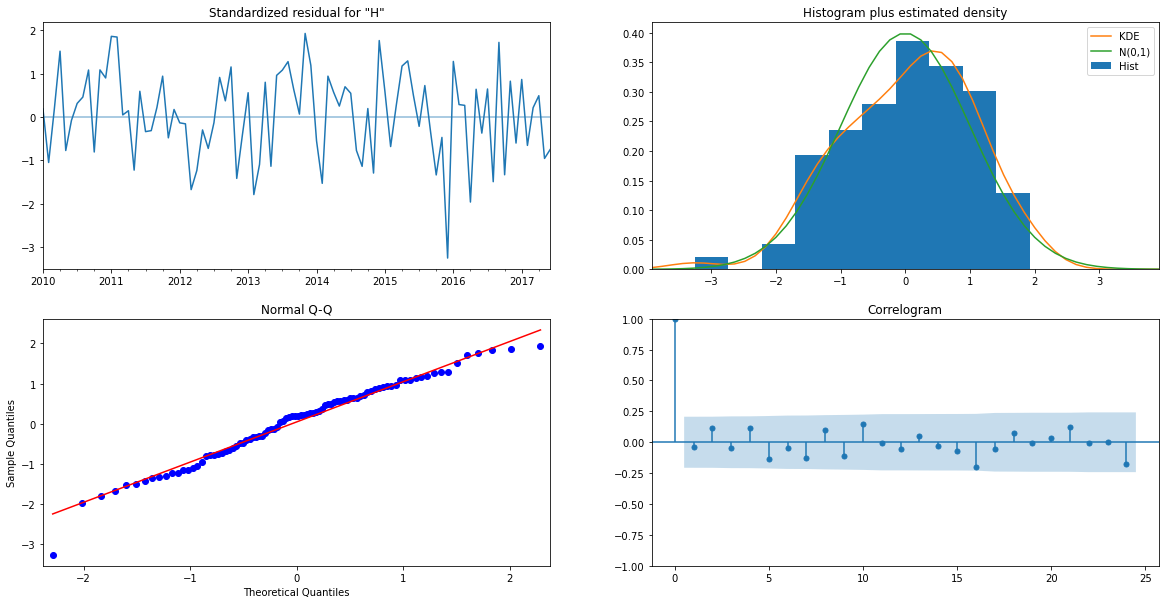

In [37]:
sar.plot_diagnostics(lags=24,figsize = (20,10),);

Diagnostics seem really good: residual shows only noise, the histogram is close to a gaussian curve and the Q-Q plot almost linear. These parameters seem adequate, let's apply them to all the features and do some predictions:

Mean RMSE value: 2.02


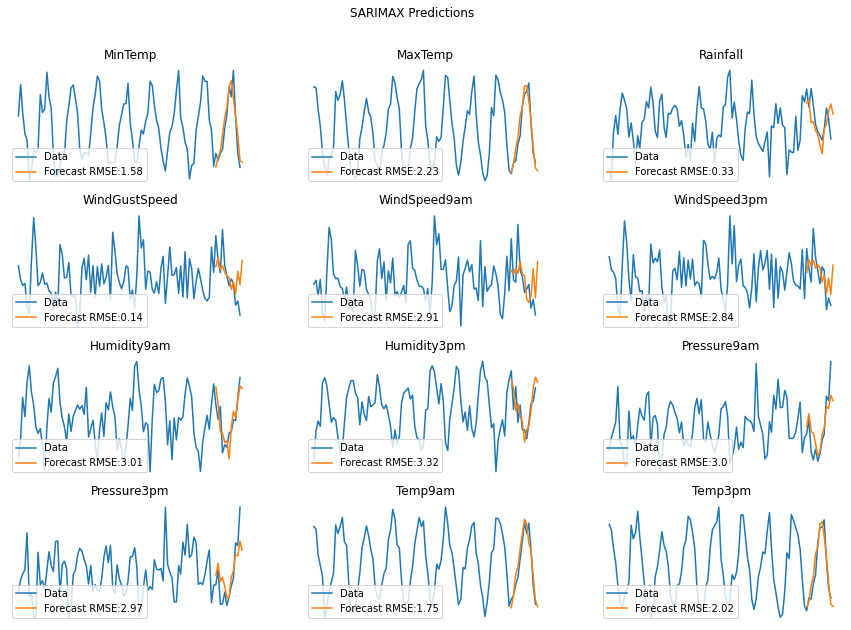

In [38]:
feature_list = df2.columns
forecast_sar = pd.DataFrame()

plt.figure(figsize=(15, 10))
plt.suptitle('SARIMAX Predictions')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
n_cols = 3
n_rows = len(feature_list) // n_cols

# We will predict between months 90 and 102 (the end).
start = 90
end = 102

rmse_list = []
for i, feature in enumerate(feature_list):
    # First, fit the model
    sar = sm.tsa.statespace.SARIMAX(df2[feature], missing='drop',
                                order=(1,0,0), 
                                seasonal_order=(1,1,1,12), 
                                trend='c').fit()
    # Then, forecast
    forecast_sar[feature] = sar.predict(start = start, end = end)
    
    # Finally, calculate the RMSE to check the quality of the prediction.
    pred = forecast_sar[feature].values
    true = df2[feature].values[start-1:]
        
    rmse = np.sqrt(np.mean((pred-true)**2))
    rmse_list.append(rmse)
    
    # And of course, plot it!
    ax = plt.subplot(n_rows, n_cols, i+1)
    plt.plot(df2[feature], label='Data')
        
    plt.plot(forecast_sar[feature], label='Forecast RMSE:' + str(round(rmse, 2)))
    plt.title(feature)
    
    leg1 = ax.legend(loc='lower left')
    plt.axis("off")
    
print('Mean RMSE value: ' + str(round(rmse.mean(), 2)))

We have an average RMSE of 2.02 and the predictions seem quite acurate. The worst performances are about wind (second row). Interestingly, those features show clearly different behaviours than the others: less seasonality, less auto-correlation as well. To get a better forecast, we should probably use different parameters for these features (even if we do know that the seasonality is 12 months, maybe another number would fit better). 

However, I decided to shift to another model to answer another issue, in my opinion way more important: the fact that most of the features are not independent. When using a SARIMAX this way, we fitted and predicted every feature independently. We know it is false and actually some features are highly correlated to each other. To take this into account we have to shift to Vector AutoRegression models or VARs.

### 3.2 VARs

VAR model is from statsmodel as well 

In [39]:
from statsmodels.tsa.api import VAR

And we will use the automatic tools to find the ideal number of lags. Interestingly, the algorithm cannot compute anything above 4 lags because of too few datapoints.

In [40]:
model = VAR(df2[:start])
x = model.select_order(maxlags=4)
x.summary()

,AIC,BIC,FPE,HQIC
0,-6.269,-5.927*,0.001893,-6.132*
1,-7.684,-3.232,0.0004734*,-5.892
2,-7.663,0.8987,0.0005781,-4.217
3,-7.978,4.693,0.0007038,-2.878
4,-8.494*,8.287,0.001312,-1.741


The minimum AIC score is for 4 lags, so let's use it. However, we cannot test until 12-15 lags as we should because of too few datapoints.

In [41]:
results = model.fit(4)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Jun, 2021
Time:                     21:47:47
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    8.28668
Nobs:                     86.0000    HQIC:                  -1.74068
Log likelihood:          -511.094    FPE:                 0.00131181
AIC:                     -8.49421    Det(Omega_mle):     5.85933e-06
--------------------------------------------------------------------
Results for equation MinTemp
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   16.676181       162.078574            0.103           0.918
L1.MinTemp               0.432710         0.306283            1.413           0.158
L1.MaxTemp               0.749980         0.72

And let's forecast on the same time-period:

In [42]:
lag_order = results.k_ar # Which means 4 in this case.

n_periods = end - start + 1

# forecasting over n_periods, by lag_order slices.
# It forecasts all the features on one go.
forecast_var = results.forecast(df2.values[-lag_order:], n_periods)

And plot the result:

Mean RMSE value: 1.65


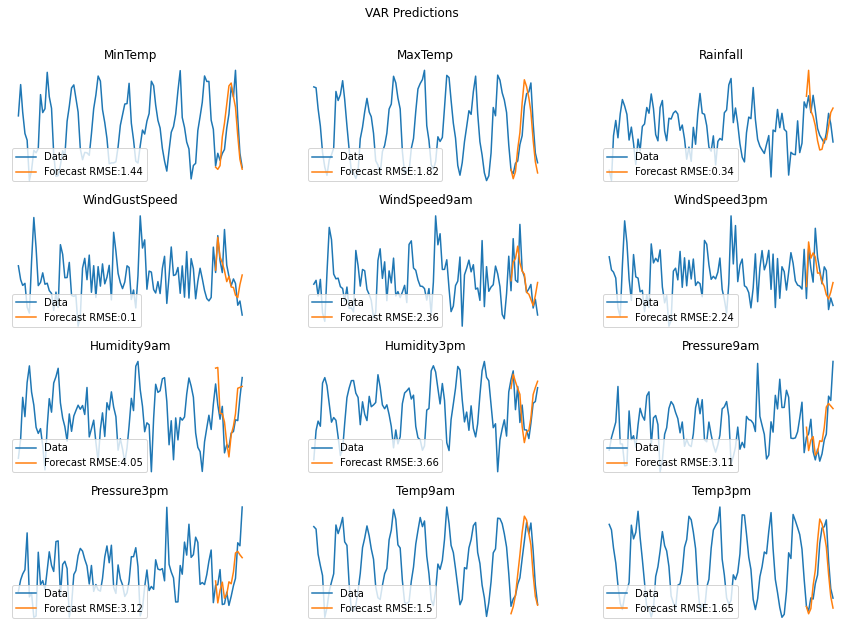

In [43]:
# Let's put the forecast in a dataframe with same feature names and same index.
forecast_var = pd.DataFrame(forecast_var)
forecast_var.columns = feature_list
forecast_var.index = df2.index[-n_periods:]

# And just plot all the graphs
plt.figure(figsize=(15, 10))
plt.suptitle('VAR Predictions')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
n_cols = 3
n_rows = len(feature_list) // n_cols

rmse_list = []
for i, feature in enumerate(feature_list):
    
    # Calculating RMSE
    pred = forecast_var[feature].values
    true = df2[feature].values[-n_periods:]
    
    rmse = np.sqrt(np.mean((pred-true)**2))
    rmse_list.append(rmse)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    plt.plot(df2[feature], label='Data')
        
    plt.plot(forecast_var[feature], label='Forecast RMSE:' + str(round(rmse, 2)))
    plt.title(feature)
    
    leg1 = ax.legend(loc='lower left')
    plt.axis("off")
    
    
print('Mean RMSE value: ' + str(round(rmse.mean(), 2)))

Average RMSE of 1.65, better than with SARIMAX. Forecasting is really nice as well. The model is easy to use.
Now we can try another model: an LSTM. 

### 3.3 LSTM
As an LSTM model can become pretty heavy I will use it to predict only a single feature: the Rainfall. The main issue was to convert the dataset to shifted time series, proper for an LSTM. I use pandas.shift for that, but it needs to do some way and back between Pandas, Numpy and the Keras data format.

In [44]:
# Found here: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
# This is actually the main thing, converting the dataset into series shifted by n_in/n_out points.

def series_to_supervised(array, n_in=1, n_out=1):
    
    df = pd.DataFrame(array)
    n_vars = array.shape[1]
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) # Using Pandas shift.
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    
    return agg

The previous function will output our features shifted by t, with the next time step concatenated after. As I want to predict the rainfall, I place the feature at the first column and I will remove all the others output columns.

In [45]:
df3 = df2[['Rainfall'] + [col for col in df2 if col not in ['Rainfall']]]

And we have to scale the dataset:

In [46]:
from sklearn.preprocessing import MinMaxScaler

# scale features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df3)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Removing all the columns we do not want to predict. Keeping only the first one, 'RainFall'
reframed.drop(reframed.columns[[i for i in range(24) if i>12]], axis=1, inplace=True)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var1(t)
1,0.100734,0.586867,0.849642,0.547294,0.380597,0.628925,0.122605,0.109565,0.195047,0.235253,0.822133,0.842481,0.000000
2,0.000000,0.870587,0.841497,0.421790,0.415601,0.510374,0.297756,0.373221,0.309483,0.338841,0.799796,0.792637,0.439956
3,0.439956,0.621224,0.651551,0.369586,0.273282,0.489491,0.674330,0.459019,0.375062,0.392587,0.572134,0.627501,0.589102
4,0.589102,0.426894,0.494149,0.387968,0.424046,0.436341,0.499428,0.412463,0.449777,0.430997,0.468723,0.492672,0.418921
5,0.418921,0.366607,0.255105,0.172907,0.119403,0.165643,0.809253,0.803860,0.772942,0.765404,0.378516,0.289880,0.651495


This is the adequate format: all the var(t-1) are the features at t-1 and we want to predict the last column, var1 at time t. So in total we have 13 columns: first 12 are inputs and the last one is the supervised output. This is using only a time-shift of 1. If we used a time shift of 2, we would need the features at t-2 and t-1, supervised output at t.

In [47]:
# split into train and test sets, back to Numpy for that.
values = reframed.values
n_train_months = 88 # (= 90 - 2) as we lose data because of shifts of 1

train = values[:n_train_months, :]
test = values[n_train_months:, :]

# split into input and outputs, output is the last column (-1 then)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] for Keras format
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print('Shapes for Train_X, train_y / test_X, test_y ')
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Shapes for Train_X, train_y / test_X, test_y 
(88, 1, 12) (88,) (13, 1, 12) (13,)


Definition of a really simple LSTM model and prediction on a Dense layer of a single neuron, as we want to predict a single value (Rainfall).

In [48]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

def model_LSTM(train_X, train_y, cell_units):
        
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1], train_X.shape[2])))
       
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
        
    return model

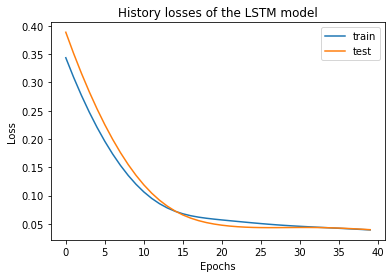

In [49]:
model = model_LSTM(train_X, train_y, 50)

# fit network
fit = model.fit(train_X, train_y, epochs=40, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='test')
plt.title('History losses of the LSTM model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

I chose the number of epochs and neurons to don't overfit much, it seems we reached a plateau here. Let's try to predict the rainfall!

In [50]:
y_pred = model.predict(test_X)

Now we have to inverse-transform the scaling, meaning we have to concatenate back the prediction and the X_test, apply the inverse scaling and then take back our predicted feature.

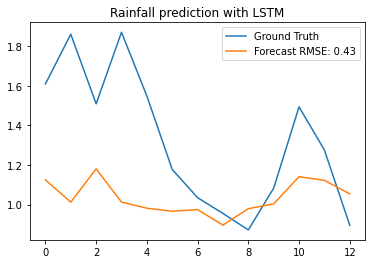

In [51]:
# Rolling back from Keras format 

test_X_res = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_ypred = np.concatenate((y_pred, test_X_res[:, 1:]), axis=1)

# invert scaling for forecast and take first column
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,0]

y_true = df2['Rainfall'].values[89:]

# calculate RMSE
rmse = np.sqrt(np.mean((y_true-inv_ypred)**2))

# And plot
plt.plot(y_true, label='Ground Truth')
plt.plot(inv_ypred, label = 'Forecast RMSE: ' + str(round(rmse,2)))
plt.title('Rainfall prediction with LSTM')
    
plt.legend(loc='upper right')


RMSE is 0.39, which is slightly worse than previous models (0.33 and 0.34 for SARIMAX and VAR, respectively). Let's plot all the predictions side by side with ground truth:

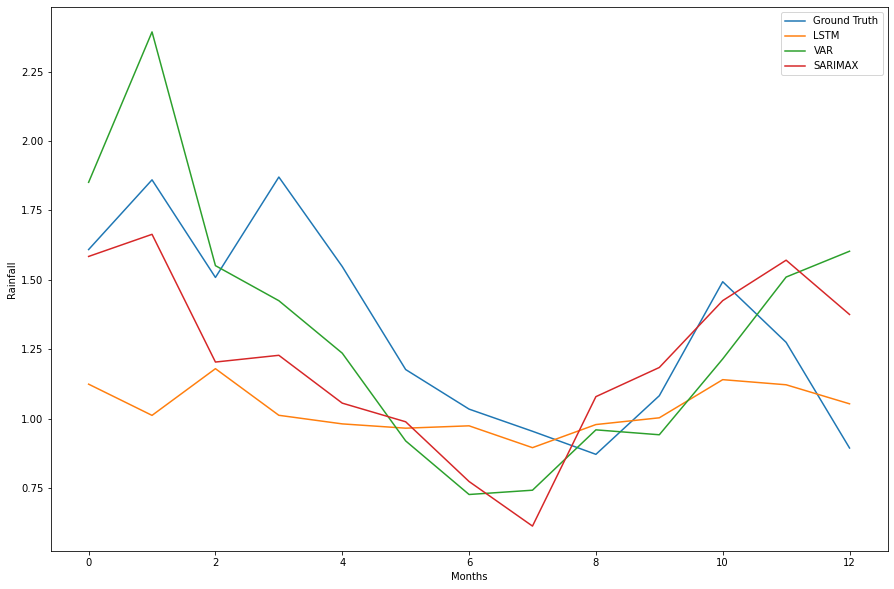

In [52]:
plt.figure(figsize=(15, 10))
plt.plot(y_true, label = 'Ground Truth')
plt.plot(inv_ypred,  label = 'LSTM')
plt.plot(forecast_var['Rainfall'].values, label = 'VAR')
plt.plot(forecast_sar['Rainfall'].values, label = 'SARIMAX')
plt.xlabel('Months')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

### Conclusion


We prepared the 'Weather in Australia' dataset and did forecasting with 12 features in total. We used a univariate SARIMAX on each feature, a multi-variate Vector Autoregression on every feature and an LSTM on every feature, predicting only a single one (Rainfall). From these tests, I could say that the VAR model is probably the best choice: easy to implement and gave the best prediction with the lowest RMSE. However there re many things to improve from this work:

First, the data cleaning and NaNs management. I decided to interpolate everything for the simplicity of it and to remove categorical variables. This could be refined for a better inpute of the data. Categorical features can be predicted as well if needed, but I did not want to mix classification and regression in the same LSTM.

Second, I decided to group all the data by months to reduce the number of observations and keep computing time low. This worked well (I actually started by keeping all the original data, it was a nightmare) but stationarity tests became fragile and VAR had difficulties to properly compute the lag. I assumed that our time series were stationaries for multiple reasons (first because they should, second because tests results were inconsistent). The best way would be to retry grouping by weeks or even keeping by days. However, as this will increase noise I am not certain the predictions will be really better.

Third, I should do some gridsearch on the SARIMAX and VAR models, to be certain the parameters are ok with those I chose. Residuals were fine, we can se the prediction is rather good, but there could be better settings.

Fourth, the LSTM architecture needs to be redone. I decided to predict a single feature for the simplicity of it, and many things are hard-coded in the functions. I should redo it to manage properly multiple features to predict, multiple steps to stride, etc... The ways and back between Keras, Numpy and Pandas were quite a pain and it should be possible to simplify this. In parallel, I shold try some other LSTM architectures (this one is the simplest possible).

Interestingly, we got some nice results with the VAR model even when chosing a lag of 4, which we now is wrong. To use a lag of 12 gives worst results as there is not enough data points to properly fit the model. I guess this is typical case of chosing between the proper parameters and the goodness of the final result.